In [ ]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import birth_death_utils as bd
import networkx as nx
from scipy.optimize import fsolve
from tabulate import tabulate
import pandas as pd
import re
from collections import Counter
from scipy.signal.windows import gaussian
from tqdm.notebook import tqdm as tqdm

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['pdf.use14corefonts'] = True 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analytic results on birth-death model 

Notations:

* $\lambda$ birth rate per node and iteration
* $\mu$ death rate per node and interation
* $\tau$ duration of the active reproduction phase
* $T$ duration of the pure death phase

see _Kendall (1948), On the Generalized Birth-and-Death Model_ (```10.1214/aoms/1177730285```)

In [7]:
def n_avg(l, m, t):
    '''
    Parameters
    ----------
    l : float
        lambda
    m : float
        mu
    t : float
        time.

    Returns
    -------
    float
        average number of living nodes at time t
    '''
    return np.exp((l - m) * t)

def P0(l, m, t):
    '''
    Probability of extinction during active reproduction phase at time t < tau
    '''
    if l != m:
        return m * (n_avg(l,m,t) -1.) /( l * n_avg(l,m,t) - m)
    else:
        return l * t / (1 + l * t)

def P(l, m, n, t):
    '''
    probability that tradition has n living witnesses during active reproduction phase at time t < tau
    '''
    return (1 - P0(l,m,t)) * (1 - eta(l,m,t)) * eta(l,m,t)**(n-1)

def eta(l, m, t):
    return (l / m) * P0(l,m,t)

def extinction_prob(l, m, tau, T):
    '''
    Probability of extinction at tau + T
    
    tau : float
        duration of the active reproduction phase
    T : float
        duration of the pure death phase.
    '''
    return P0(l,m,tau) + (1. - P0(l,m,tau)) * (1. / eta(l,m,tau) - 1.) * (1. / (1. - eta(l,m,tau) * (1. - np.exp(-m*T)) ) - 1.)
    
def avg_surviving_witnesses(l, m, tau, T):
    return np.exp((l-m) * tau) * np.exp(-m*T)

def P_n(l, m, tau, T, n):
    '''
    Probability distribution of the number of living nodes per tree at tau + T
    '''
    K = (1. - P0(l, m, tau)) * (1. / eta(l, m, tau) - 1.) / (1 - eta(l, m, tau) * (1 - np.exp(- m * T)))
    S = ((eta(l, m, tau) * (1 - np.exp(- m * T))) / ((np.exp(m * T) - 1) * (1 - eta(l, m, tau) * (1 - np.exp(- m * T)))))**n
    return K * S


def median(l, m, tau, T):
    '''
    Median number of survivng witnesses
    '''
    K = (1. - P0(l, m, tau)) * (1. / eta(l, m, tau) - 1.) / (1 - eta(l, m, tau) * (1 - np.exp(- m * T)))
    r = (eta(l, m, tau) * (1 - np.exp(- m * T))) / ((np.exp(m * T) -1 ) * (1 - eta(l, m, tau) * (1 - np.exp(- m * T))))
    s = 1 - extinction_prob(l, m, tau, T)
    return np.log((1 - (s / (2 * K) + 1) * (1. - r))) / np.log(r)

def cumul_pop(l, m, tau, T):
    '''
    Total number of nodes generated at tau + T
    '''
    if l != m:
        return 1. + l / (l-m) * (np.exp((l-m) * tau) - 1.)
    else:
        return (1 + l * tau)


def chao1_survival_rate_work(l, m, tau, T):
    '''
    Value of the Chao1 richness estimator on survival rate of trees/traditions
    '''
    return (1-extinction_prob(l,m,1000,1000)) + P_n(l, m, tau, T, 1)**2 / (2 * P_n(l, m, tau, T, 2))

def chao1_survival_rate_documents(l, m, tau, T, K_trad):
    '''
    Value of the Chao1 richness estimator on survival rate of nodes
    '''
    f1 = P_n(l, m, tau, T, 1) * K_trad
    f2 = P_n(l, m, tau, T, 2) * K_trad
    func = lambda x: 2*(1+x) * f1  - np.exp((2*f2/f1)*x)
    xs = fsolve(func, 20)[0]
    chao1_docs = (1+xs)
    return chao1_docs

def avg_size_surv(l,m,tau,T):
    return sum([n*P_n(l, m, tau, T, n) for n in range(100)])/(1-extinction_prob(l,m,tau,T))

# Generate simulated traditions

We generate a number ```trad_nb``` of trees for each point in parameter space, for $\lambda$ (resp. $\mu$) ranging between ```lambda_min``` (```mu_min```) and ```lambda_max``` (```mu_max```) with ```lambda_mesh``` (```mu_mesh```) distinct values.
Data are stored in ```path``` with distinct directory for each parameter point.
Data can be stored as pickle dump of ```nx.DiGraph``` (```'serialized'```, faster to load within python) or as a csv file (```csv```).

In [8]:
lambda_min=4*10**(-3)
lambda_max=9*10**(-3) 
mu_min=2*10**(-3) 
mu_max=6*10**(-3)

lambda_mesh=10
mu_mesh=10

mu_range = np.linspace(mu_max, mu_min, mu_mesh)
lambda_range = np.linspace(lambda_min, lambda_max, lambda_mesh)

lambda_labels = [r'%.1f'%n for n in (10**(3))*lambda_range]
mu_labels = [r'%.1f'%n for n in (10**(3))*mu_range]

Nact=1000
Ninact=1000

trad_nb=100
path='simulations'
output_format='serialized'

In [36]:
if not os.path.exists(f'{path}'):
    os.mkdir(f'{path}')

progress = tqdm(total = mu_mesh * lambda_mesh * trad_nb)

for i in range(mu_mesh):
    for j in range(lambda_mesh):
        for k in range(trad_nb):
            l = lambda_range[j]
            m = mu_range[i]

            point_path = f'{path}/lambda={lambda_labels[j]}_mu={mu_labels[i]}'

            if not os.path.exists(point_path):
                os.mkdir(point_path)

            g = bd.generate_tree(l, m, Nact, Ninact)

            if output_format == 'serialized':
                os.system(f'touch {point_path}/{k}')
                with open(f'{point_path}/{k}', 'wb') as f:
                    pickle.dump(g, f)

            if output_format == 'csv':
                bd.csv_dump(g, f'{point_path}/{k}')
            
            progress.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]

# Plots of phase diagrams

## Survival rates and median witness numbers

These quantities can be computed analytically with the functions defined above

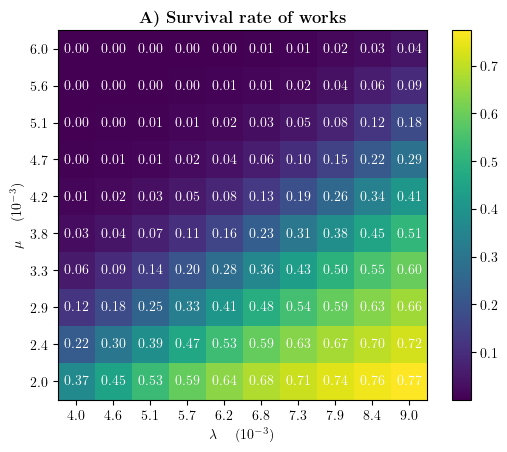

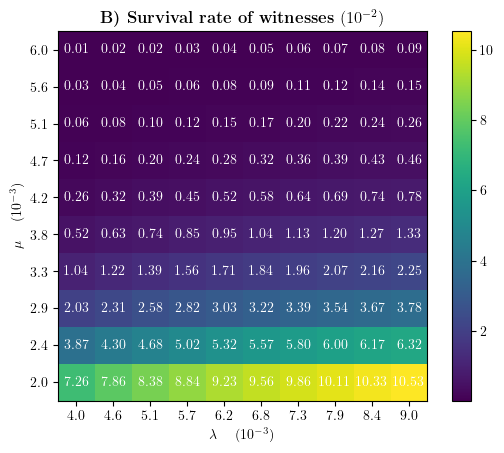

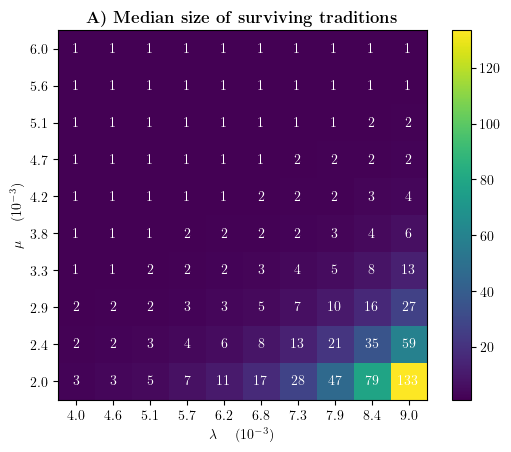

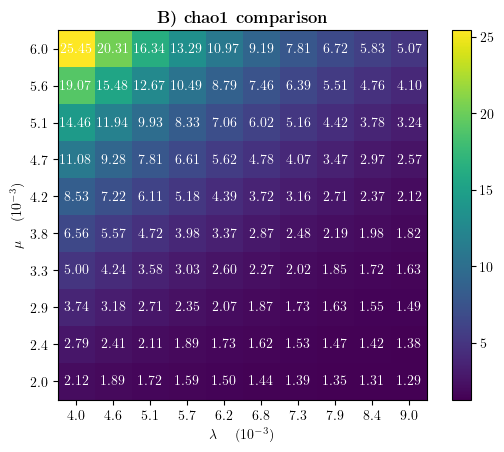

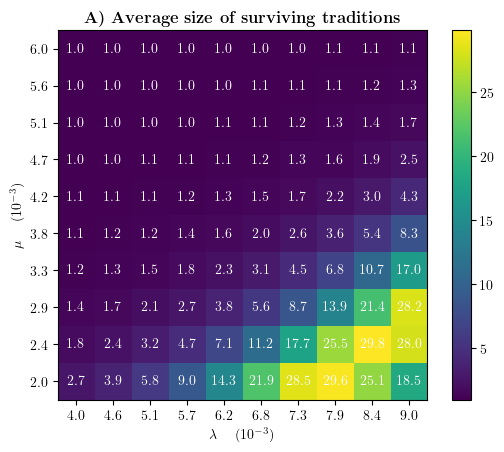

In [ ]:
plots = {'srw' : {'data' : [], 'line' : [], 
                      'label' : r'\textbf{A) Survival rate of works}', 'precision' : 2},
             'srm' : { 'data' : [], 'line' : [], 
                      'label' : r'\textbf{B) Survival rate of witnesses} ($10^{-2}$)', 'precision' : 2},
             'msts' : {'data' : [], 'line' : [], 
                       'label' :  r'\textbf{A) Median size of surviving traditions}', 'precision' : 0},
              'chao1' : { 'data' : [], 'line' : [], 
                      'label' : r'\textbf{B) chao1 comparison}', 'precision' : 2},
              'avg' :  {'data' : [], 'line' : [], 
                       'label' :  r'\textbf{A) Average size of surviving traditions}', 'precision' : 1}}

for i in range(len(mu_range)):
    
    for data in plots.keys():
        plots[data]['line'] = []
            
    for j in range(len(lambda_range)):

        l = lambda_range[j]
        m = mu_range[i]

        plots['srw']['line'].append(1. - extinction_prob(l, m, 1000, 1000))
        plots['avg']['line'].append(avg_size_surv(l, m, 1000, 1000))
        plots['msts']['line'].append(median(l, m, 1000, 1000))
        plots['srm']['line'].append(100 * avg_surviving_witnesses(l, m, 1000, 1000) / cumul_pop(l, m, 1000, 1000))
        plots['chao1']['line'].append(1. / chao1_survival_rate_work(l,m,1000,1000))
    for data in plots.keys():
            plots[data]['data'].append(plots[data]['line'])
    
for plot in plots.values():
    bd.plot_heatmap(plot['data'], plot['label'], lambda_labels, mu_labels, plot['precision'])

## Observables from simulated data

In [ ]:
path = 'simulations'

# plots: list of generated plots with corresponding 
## data array (data)
## title of the plot (label)
## precision of the ticks displayed on the diagramm (precision)

plots= {'median_time_living' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{A) Median birth time of surviving witnesses}', 'precision' : 0},
        'median_time_ow' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{B) Median birth time of oldest witnesses}', 'precision' : 0},
        'oldest_newest_dist' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{C) Median timelapse between oldest and newest witnesses}', 'precision' : 0},
        'direct_descents' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{D) Number of direct filiation between witnesses}', 'precision' : 1},
        'deg2' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{E) Proportion of internal nodes with out-degree 2}', 'precision' : 2},
        'deg3' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{E) Proportion of internal nodes with out-degree 3}', 'precision' : 2},
        'root_deg2' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{F) Proportion of trees with root-degree 2}', 'precision' : 2},
        'dist_gen_arch' : {'data' : [], 'line' : [], 
                'label' : r'\textbf{E) Original - archetype median distance}', 'precision' : 1}}

progress = tqdm(total = mu_mesh * lambda_mesh * trad_nb)

for i in range(len(mu_range)):

    for data in plots.keys():
        plots[data]['line'] = []

    for j in range(len(lambda_range)):

        l = lambda_range[j]
        m = mu_range[i]

        trees = []                  # all trees at phase diagram point
        living_trees = []           # all trees with at least one surviving witness
        stemmatizable_trees = []    # all trees with at least three surviving witnesses 

        for k in range(0,trad_nb):
            progress.update(1)
            with open(f'{path}/lambda={lambda_labels[j]}_mu={mu_labels[i]}/{k}', 'rb') as f:
                g = pickle.load(f)
            trees.append(g)
            n = list(nx.get_node_attributes(g, 'state').values()).count(True)
            if n >  0:
                living_trees.append(g)
                if n >= 3:
                    stemmatizable_trees.append(g)

        # computation of median birth time of all witnesses and oldest witesses

        birth_times = []
        birth_times_ow = []
        birth_times_diff = []

        for g in living_trees:
            birth_times_trad = []
            for n in g.nodes():
                if g.nodes[n]['state']:
                    birth_times_trad.append(g.nodes[n]['birth_time'])
            birth_times += birth_times_trad
            birth_times_ow.append(min(birth_times_trad))
            birth_times_diff.append(max(birth_times_trad)-min(birth_times_trad))

        # computation of direct witness filiations density

        direct_descents = []
        for g in living_trees:
            st = bd.generate_stemma(g)
            direct_descents.append(bd.count_direct_filiation(st))

        # computation of the proportion of internal nodes with out-degree 2 and degree distributions
        
        degrees = []
        orig_arch_dists = []
        root_degree_equal_2 = 0
        for g in stemmatizable_trees:
            st =  bd.generate_stemma(g)

            original = bd.root(g)
            archetype = bd.root(st)
            orig_arch_dists.append(len(nx.shortest_path(g, source = original, target = archetype)))

            if st.out_degree(bd.root(st)) == 2:
                root_degree_equal_2 += 1
            for n in bd.internal_nodes(st):
                degrees.append(st.out_degree(n))

        degs = Counter(degrees)

        TRAD_MIN = 10

        # In case the number of relevant traditions generated for a given (lambda, mu) and observable is less than TRAD_MIN, the corresponding
        # data point is set to NaN on the plot

        if len(birth_times) >= TRAD_MIN:
            plots['median_time_living']['line'].append(np.median(birth_times))
        else:
            plots['median_time_living']['line'].append(float('nan'))
        
        if len(birth_times_ow) >= TRAD_MIN:
            plots['median_time_ow']['line'].append(np.median(birth_times_ow))
        else:
            plots['median_time_ow']['line'].append(np.median(float('nan')))
        
        if len(birth_times_diff) >= TRAD_MIN:
            plots['oldest_newest_dist']['line'].append(np.median(birth_times_diff))
        else:
            plots['oldest_newest_dist']['line'].append(float('nan'))

        
        plots['direct_descents']['line'].append(np.mean(direct_descents) * 10**2)

        
        if len(degrees) > TRAD_MIN:
            plots['deg2']['line'].append(degs[2] / sum(degs.values()))
            plots['deg3']['line'].append(degs[3] / sum(degs.values()))
            plots['root_deg2']['line'].append(root_degree_equal_2 / len(stemmatizable_trees))
        else:
            plots['deg2']['line'].append(float('nan'))
            plots['deg3']['line'].append(float('nan'))
            plots['root_deg2']['line'].append(float('nan'))
        if len(orig_arch_dists) > TRAD_MIN:
            plots['dist_gen_arch']['line'].append(np.median(orig_arch_dists))
        else:
            plots['dist_gen_arch']['line'].append(float('nan'))
    for data in plots.keys():
        plots[data]['data'].append(plots[data]['line'])

for plot in plots.values():
    bd.plot_heatmap(plot['data'], plot['label'], lambda_labels, mu_labels, plot['precision'])








/home/ugodreau/repo_clean/ExtinctionOfTexts/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ugodreau/repo_clean/ExtinctionOfTexts/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)














Exception ignored in: <function tqdm.__del__ at 0x7af1ae2571a0>
Traceback (most recent call last):
  File "/home/ugodreau/repo_clean/ExtinctionOfTexts/.venv/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/ugodreau/repo_clean/ExtinctionOfTexts/.venv/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7af1ae2571a0>
Traceback (most r

KeyboardInterrupt: 

# Comparison with real stemmata

Data are obtained from the **OpenStemmata** database (https://openstemmata.github.io/index.html).

Our dataset consists in stemmata of Old French chivalric texts. Stemmata, stored as ```.dot``` files, in the directory ```corpus_stemmata/```. They are first loaded and regularized by eliminating contaminations, dubious paternity and mentions of unattested originals or non branching archetypes



In [13]:
def load_from_OpenStemmata(file):
    '''
    returns a nx.DiGraph() tree from database .dot files
    '''
    G = nx.nx_pydot.read_dot(file)
    
    # remove uncertain paternity
    edges_pt = nx.get_edge_attributes(G, 'style')
    for edge, pt in edges_pt.items():
        if pt =='dashed':
            G.remove_edge(*edge)
    
    # remvove singletons and extra-stemmatic contaminations
    singletons = []
    for node in G.nodes():
        if G.in_degree(node) == 0 and G.out_degree(node) == 0:
            singletons.append(node)
    G.remove_nodes_from(singletons)
    
    # remove intra-stemmatic contaminations
    for node in G.nodes():
        in_neighbors = list(G.predecessors(node))
        if G.in_degree(node) > 1:
            contaminations = np.random.choice(in_neighbors, len(in_neighbors) -1, replace=False)
            for parent in contaminations:
                G.remove_edge(parent, node)
    
    # identify survivng witnesses
    colors = nx.get_node_attributes(G, 'color')
    living = {}
    for node in G.nodes():
        if node in colors.keys():
            living[node] = False
        else:
            living[node] = True
    nx.set_node_attributes(G, living, 'state')
    
    # remove non-branching unattested nodes
    st = bd.generate_stemma(G)
    return st

In [14]:
wholeCorpus = {}
for work in os.listdir(f'corpus_stemmata/'):
    print(f'{work}')
    st = load_from_OpenStemmata(f'corpus_stemmata/{work}/stemma.gv')
    wholeCorpus[f"{work}"] = st

Karsch_1907_Gaydon
Leonardi_2003_MortArtu
Heriche_2000_WauquelinAlexandre
Salverda_1888_Eneas
Herbin_2018a_Anseys
Constans_1890_Thebes
Nelson_1985_ChevCygne
CourayeduParc_1884_MortAimeri
Loeseth_1890_GautierdArras-Eracle
Zorn_1908_EnfViv
Sweetser_1964_Blancandin
Stimming_1920_BeuveHanstCont3-3
Ponceau_1997b_SaintGraal
Zink_1984_Cleriadus
Cloetta_1911_Moniage2
Korte_1914_RenMont2
Nelson_1985_NaissanceChevCygne
Langlois_1888_CourLouis
Nelson_1985_FinElias
Blanchard_1976_TristanProseV1
Myers_1981_Chetifs1
Rochebouet_2021_RTroieProse5-2
Stimming_1918_BeuveHanstCont2-3
Gundlach_1883_SiegeBarbastre
Stimming_1920_BeuveHanstCont3-4
Stimming_1920_BeuveHanstCont3-2
Rolin_1897_Aliscans2-Rainouart
Stengel_1882_GarinMonglane
Saly_1990_GirartdAmiens-Meliacin
Demaison_1887_Aimeri
Segre_1971_Roland
Grillo_1984_ChretienteCorbaran
Cloetta_1911_Moniage1
Veneziale_2020_Guiron-Cont
Myers_1981_Chetifs2
Clive_1959_FloridanEtElvide
Ponceau_1997c_SaintGraal
Treutler_1880_Otinel
Korte_1914_RenMont1
Myers_1981_C

## Topological properties of stemmata

We now compute various stemmatic properties on the normalized real stemmata found on the OpenStemmata database. Lower and upper 10 % confidence bound are computed by bootstraping, by means of the ```bd.bootstraped``` decorator

In [ ]:
@bd.bootstraped
def prop_degree_2(trees):
    '''
    Returns the proportion of internal (non-leaf) nodes of degree two
    in a list of trees
    '''
    nb_deg_2 = 0
    nb_internal_nodes = 0
    for g in trees:
        for n in g.nodes():
            nb_internal_nodes += len(bd.internal_nodes(g))
            if g.out_degree(bd.root(g)) == 2:
                nb_deg_2 +=1
    return nb_deg_2 / nb_internal_nodes

@bd.bootstraped
def prop_degree_3(trees):
    '''
    Returns the proportion of internal (non-leaf) nodes of degree three
    in a list of trees
    '''
    nb_deg_3 = 0
    nb_internal_nodes = 0
    for g in trees:
        for n in g.nodes():
            nb_internal_nodes += len(bd.internal_nodes(g))
            if g.out_degree(bd.root(g)) == 3:
                nb_deg_3 +=1
    return nb_deg_3 / nb_internal_nodes


@bd.bootstraped
def bifidity(trees):
    '''
    Return the proportion of trees with root-degree two in a list of trees
    '''
    nb_bifid = 0
    for g in trees:
        if g.out_degree(bd.root(g)) == 2:
            nb_bifid +=1
    return nb_bifid / len(trees)

@bd.bootstraped
def count_direct_filiation(g):
    '''
    Return the proportion of edges connecting living witnesses
    '''
    direct_descents = 0
    nb_edges = 0
    for g in trees:
        for (i,j) in g.edges():
            nb_edges += 1
            if g.nodes[i]['state'] and g.nodes[j]['state']:
                direct_descents += 1
    return direct_descents / nb_edges

@bd.bootstraped
def i3(trees):
    indices = []
    for g in trees:
        if len(bd.leaves(g)) >= 3:
            indices.append(bd.imbalance_proportion(g))
    return np.mean(indices)

In [14]:
stemmata = list(wholeCorpus.values())

deg2 = prop_degree_2(stemmata)
deg3 = prop_degree_3(stemmata)
bif = bifidity(stemmata)
direct = count_direct_filiation(stemmata)
imb = i3(stemmata)


results_chGeste = [['observable','estimated value', 'lower bound', 'upper bound'],
                   ['prop. bifid stemmata', f'{bif[0]:.2f}', f'{bif[1]:.2f}', f'{bif[2]:.2f}'],
                   ['i3 imbalance', f'{imb[0]:.2f}', f'{imb[1]:.2f}', f'{imb[2]:.2f}'],
                   ['prop. of deg-2 internal nodes', f'{deg2[0]:.2f}', f'{deg2[1]:.2f}', f'{deg2[2]:.2f}'],
                   ['prop. of deg-3 internal nodes', f'{deg3[0]:.2f}', f'{deg3[1]:.2f}', f'{deg3[2]:.2f}'],
                   ['prop. of direct witness descents', f'{direct[0]:.2f}', f'{direct[1]:.2f}', f'{direct[2]:.2f}']]
                  
print(tabulate(results_chGeste, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════════════════╤═══════════════════╤═══════════════╤═══════════════╕
│ observable                       │   estimated value │   lower bound │   upper bound │
╞══════════════════════════════════╪═══════════════════╪═══════════════╪═══════════════╡
│ prop. bifid stemmata             │              0.75 │          0.75 │          0.75 │
├──────────────────────────────────┼───────────────────┼───────────────┼───────────────┤
│ i3 imbalance                     │              0.1  │          0.1  │          0.1  │
├──────────────────────────────────┼───────────────────┼───────────────┼───────────────┤
│ prop. of deg-2 internal nodes    │              0.08 │          0.08 │          0.08 │
├──────────────────────────────────┼───────────────────┼───────────────┼───────────────┤
│ prop. of deg-3 internal nodes    │              0.02 │          0.02 │          0.02 │
├──────────────────────────────────┼───────────────────┼───────────────┼───────────────┤
│ prop. of direct wit

# Witness number distribution of traditions

We now compute the distribution of witnesses number (i.e. the number of works in the database with given number of known witnesses) of our corpus. Texts are uniquely identified on the database by the ```text H-ID``` entry.

In [24]:
df = pd.read_csv("Old_French_witnesses.csv")

In [25]:
works = set(list(df['text H-ID']))
size_frags_d = []
size_d = []
for work in works:
    n_wit = len(df[(df['text H-ID'] == work) & (df['status'] != 'fragment')])
    n_frags = len(df[(df['text H-ID'] == work) & (df['status'] == 'fragment')])
    if n_wit !=0:
        size_d.append(n_wit)
    if n_frags !=0:
        size_frags_d.append(n_frags)

size_dist = Counter(size_d)
size_dist_frags = Counter(size_frags_d)


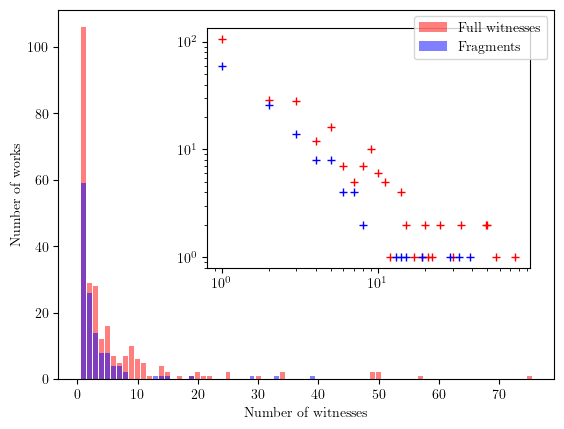

In [26]:
fig, ax1 = plt.subplots()

xw = np.array(list(size_dist.keys()))
xf = np.array(list(size_dist_frags.keys()))
yw = np.array(list(size_dist.values()))
yf = np.array(list(size_dist_frags.values()))

left, bottom, width, height = [0.3, 0.3, 0.65, 0.65]
ax2 = ax1.inset_axes([left, bottom, width, height])

ax2.loglog(xw, yw, 'r+')
ax2.loglog(xf, yf, 'b+')

ax1.bar(xw,yw, color = 'r', alpha = 0.5, label='Full witnesses')
ax1.bar(xf,yf,color = 'b', alpha = 0.5, label='Fragments')

ax1.set_ylabel(r'Number of works')
ax1.set_xlabel(r'Number of witnesses')
ax1.legend()

# Time distribution of witnesses

In [27]:
df = pd.read_csv("Old_French_witnesses.csv")

In [28]:
def convert_dates(s):
    '''convert a string to a normalized date format, i.e. a single int or a 2-uple (int, int)
    corresponding to a date range.
    '''
    pattern1 = re.compile('[0-9][0-9][0-9][0-9]')
    pattern2 = re.compile('[0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9]')
    if s == 'NaN' or pd.isna(s):
        return None

    if bool(pattern1.fullmatch(s)):
        return int(s)
    if bool(pattern2.fullmatch(s)):
        xx = s.split('-')
        return (int(xx[0]), int(xx[1]))

def load_dates(dates):
    '''
    Load and normalize the dates of manuscripts from a csv table of witnesses (TO BE MODIFIED WHEN DATA ARE CLEAN)
    '''
    dates = list(filter(lambda x:x != 'NaN', dates))
    dates = list(filter(lambda x:not pd.isna(x), dates))
    pattern = re.compile('[0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9]|[0-9][0-9][0-9][0-9]')
    dates = [pattern.findall(x) for x in dates]
    dates = [x[0] for x in dates if not x==[]]

    pattern1 = re.compile('[0-9][0-9][0-9][0-9]')
    pattern2 = re.compile('[0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9]')

    dates_f = []
    points = []              # contains dates given as single years
    intervals = []           # contains dates given as ranges

    for x in dates:
        if bool(pattern1.fullmatch(x)):
            dates_f.append(int(x))
            points.append(int(x))
        if bool(pattern2.fullmatch(x)):
            xx = x.split('-')
            dates_f.append((int(xx[0]),int(xx[1])))
            intervals.append((int(xx[0]),int(xx[1])))
    return dates_f, points, intervals

def dates_to_distrib(dates):
    '''
    Convert a list of dates (given as single years or ranges) to a manuscript production date distribution
    '''
    dates_full, points, intervals = load_dates(dates)

    years_distrib = {y:0 for y in range(1100,1601)}


    for x in points:
        if 1000 <= x <= 1600:
            years_distrib[x] +=1

    for xl, xh in intervals:
        if 1100 <= xl <= 1600 and 1100 <= xh <= 1600:
            for i in range(xl, xh):
                years_distrib[i] += 1/len(list(range(xl, xh)))
    return years_distrib

In [29]:
years_full = dates_to_distrib(df[df['status'] != 'fragment']['Date'])              # select only complete manuscripts as witnesses
years_frags = dates_to_distrib(df[df['status'] == 'fragment']['Date'])             # select only fragmentary witnesses 

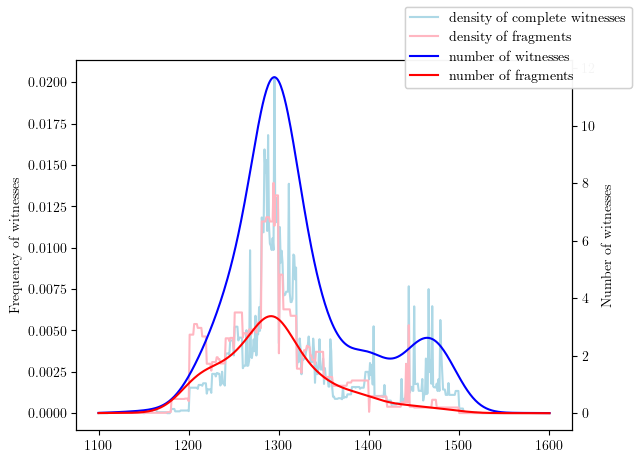

In [30]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(years_full.keys(), np.array(list(years_full.values()))  / sum(years_full.values()), color='lightblue', label = 'density of complete witnesses')

K =(1/sum(gaussian(500,20))) * gaussian(500, 20)                                # kernel density estimate of the probability density of witnesses
density_smooth = np.convolve(np.array(list(years_full.values())), K, 'same')

ax2.plot(years_full.keys(), density_smooth, 'b-', label = 'number of witnesses')


ax1.plot(years_frags.keys(), np.array(list(years_frags.values()))  / sum(years_frags.values()), color='lightpink', label = 'density of fragments')

K =(1/sum(gaussian(500,20))) * gaussian(500, 20)                                # kernel density estimate of the probability density of witnesses
density_smooth = np.convolve(np.array(list(years_frags.values())), K, 'same')

ax2.plot(years_frags.keys(), density_smooth, 'r-', label = 'number of fragments')

ax1.set_ylabel('Frequency of witnesses')
ax2.set_ylabel('Number of witnesses')
fig.legend()
fig.legend()

# Median lifespan of traditions

We finally compute the median lifespan of traditions defined as the time interval between the production date of the oldest and the newest witness of a given text.

In [31]:
def top(x):
    '''
    Upper bound on witness date (single year or range)
    '''
    match x:
        case (x1, x2):
            return x2
        case _:
            return x

def bottom(x):
    '''
    Lower bound on witness date (single year or range)
    '''
    match x:
        case (x1, x2):
            return x1
        case _:
            return x

ranges_per_work = {}
for work in set(df['text H-ID']):
    t_dates = [convert_dates(s) for s in list(df[df['text H-ID'] == work]['Date']) if convert_dates(s) != None]
    if t_dates != []:
        lb = sorted(t_dates, key=bottom)[0]
        ub = sorted(t_dates, key=top)[-1]
        ranges_per_work[work] = (lb,ub)

In case one or both of the extremal witnesses are dated in (possibly overlaping) ranges, the time interval between these witnesses is estimated by the expection value of the difference between two random dates drawn within these ranges with uniform probability, which is computed by the functions below

In [32]:
def expected_abs_diff_degenerate(c, a, b):
    '''
    Returns the expectation value of the timelapse between one date given as range
    and one other as a single year
    '''
    if a == b:
        return abs(a - c)
    if a <= c <= b:
        return ((c-a)**2 + (b-c)**2) / (2*(b-a))
    elif c < a:
        return (a+b)/2 - c
    else: 
        return c - (a+b)/2

def expected_abs_diff(a, b, c, d):
    '''
    Return the expectation value of the timelapse between two dates given as
    intervals
    '''
    if a == b:
        return expected_abs_diff_degenerate(a, c, d)
    if c == d:
        return expected_abs_diff_degenerate(c, a, b)
    elif a < b < c < d:
        return (c+d-b-a)/2
    elif a <= c <= d < b:
        return (1/(b-a)) * ((1/2)*((d-a)*(c-a)+(b-d)*(b-c)) + (1/3)*(d-c)**2)
    elif a <= c <= b <= d:
        return (1/(b-a)) * ((1/2)* ((c-a)*(d-a) + (b-c)*(d-b)) + (1/(3*(d-c)))*(b-c)**3 )
    else:
        raise ValueError("Must have a < b, c < d, and a < c")

lifespans = []
for w,v in ranges_per_work.items():
    match v:
        case [(a,b), (c,d)]:
            lifespans.append(expected_abs_diff(a,b,c,d))
        case [(a,b), c]:
            lifespans.append(expected_abs_diff_degenerate(a,b,c))
        case [c,(a,b)]:
            lifespans.append(expected_abs_diff_degenerate(a,b,c))
        case [a,b]:
            lifespans.append(abs(a-b))
        case _:
            print('error')

In [33]:
np.median(lifespans)

50.54608046274713